In [23]:
import numpy as np
import cv2

Aufgabe a (übernommen aus letzter Abgabe)

In [24]:
def compute_homography(src, dst):
    """dst ≃ H·src  (homogene)."""
    A = []
    for (x, y), (u, v) in zip(src, dst):
        A.extend([
            [-x, -y, -1,  0,  0,  0, u*x, u*y, u],
            [ 0,  0,  0, -x, -y, -1, v*x, v*y, v]
        ])
    A = np.asarray(A, dtype=float)
    _, _, vh = np.linalg.svd(A)
    h = vh[-1] / vh[-1, -1]          # Normierung → h33 = 1
    return h.reshape(3, 3)


In [25]:
Haus1 = [[1520, 1077], [4513, 1221], [4581, 2961], [1381, 2885]]
Haus2 =  [[2389, 877], [3993, 837], [4017, 2557], [2465, 2577]]
Haus3 = [[3309, 733,], [4885, 761], [4921, 3737], [3153, 3561]]
Haus4 = [[945, 681], [3817, 621], [4165, 2449], [1527, 2477]]

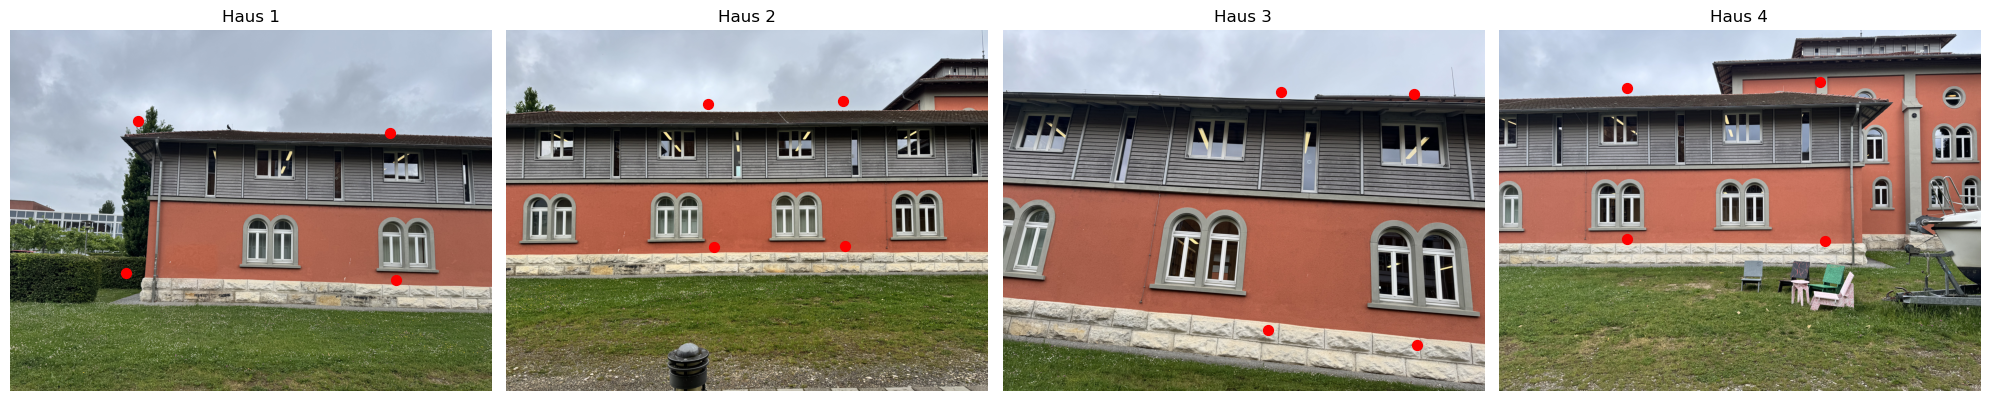

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
Haus1 = [[1520, 1077], [4513, 1221], [4581, 2961], [1381, 2885]]
Haus2 = [[2389, 877],  [3993, 837],  [4017, 2557], [2465, 2577]]
Haus3 = [[3309, 733],  [4885, 761],  [4921, 3737], [3153, 3561]]
Haus4 = [[1521, 689],   [3817, 621],  [3873, 2509], [1527, 2477]]
haus_punkte = [Haus1, Haus2, Haus3, Haus4]
dateien = [
    "../data/stiching/bib_1.jpeg",
    "../data/stiching/bib_2.jpeg",
    "../data/stiching/bib_3.jpeg",
    "../data/stiching/bib_4.jpeg"
]
def visualize_points(haus_punkte, dateien):

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for idx, (coords, fname) in enumerate(zip(haus_punkte, dateien)):
        img = Image.open(fname)
        axs[idx].imshow(img)
        axs[idx].axis('off')
        x = [pt[0] for pt in coords]
        y = [pt[1] for pt in coords]
        axs[idx].scatter(x, y, c='r', s=50)
        axs[idx].set_title(f"Haus {idx+1}")
    plt.tight_layout()
    plt.show()

visualize_points(haus_punkte, dateien)

In [27]:
Haus1_pts_img = [[1520, 1077], [4513, 1221], [4581, 2961], [1381, 2885]]
Haus2_pts_img = [[2389, 877],  [3993, 837],  [4017, 2557], [2465, 2577]]
Haus3_pts_img = [[3309, 733],  [4885, 761],  [4921, 3737], [3153, 3561]]
Haus4_pts_img = [[1521, 689],  [3817, 621],  [3873, 2509], [1527, 2477]]
haus_punkte_img = [
    np.array(Haus1_pts_img, dtype=np.float32),
    np.array(Haus2_pts_img, dtype=np.float32),
    np.array(Haus3_pts_img, dtype=np.float32),
    np.array(Haus4_pts_img, dtype=np.float32)
]

dateien = [
    "../data/stiching/bib_1.jpeg",
    "../data/stiching/bib_2.jpeg",
    "../data/stiching/bib_3.jpeg",
    "../data/stiching/bib_4.jpeg"
]

for fname in dateien:
    try:
        with open(fname, 'rb') as f:
            pass
    except FileNotFoundError:
        print(f"Warning: File {fname} not found. Creating dummy image.")
        dummy_img = np.zeros((600, 800, 3), dtype=np.uint8)
        cv2.imwrite(fname, dummy_img)


world_coords_h1 = np.array([[0, 0], [1000, 0], [1000, 600], [0, 600]], dtype=np.float32)

world_coords_h2 = np.array([[800, 0], [1800, 0], [1800, 600], [800, 600]], dtype=np.float32)


all_image_points_user = [haus_punkte_img[0], haus_punkte_img[1]]
all_world_points_user = [world_coords_h1, world_coords_h2]


def visualize_points(haus_punkte_vis, dateien_vis):
    fig, axs = plt.subplots(1, len(dateien_vis), figsize=(5 * len(dateien_vis), 5))
    if len(dateien_vis) == 1: # if only one image, axs is not a list
        axs = [axs]
    for idx, (coords, fname) in enumerate(zip(haus_punkte_vis, dateien_vis)):
        try:
            img = Image.open(fname)
            axs[idx].imshow(img)
            axs[idx].axis('off')
            if coords:
                x = [pt[0] for pt in coords]
                y = [pt[1] for pt in coords]
                axs[idx].scatter(x, y, c='r', s=50)
            axs[idx].set_title(f"Image {idx+1}")
        except FileNotFoundError:
            axs[idx].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            axs[idx].set_title(f"Image {idx+1} (not found)")
            axs[idx].axis('off')
    plt.tight_layout()
    plt.show()

In [28]:
def calculate_pixel_weights(image_height, image_width):
    j_indices = np.arange(image_height)
    i_indices = np.arange(image_width)

    weight_j = 1.0 - (2.0 / image_height) * np.abs(j_indices - (image_height - 1) / 2.0)
    weight_i = 1.0 - (2.0 / image_width)  * np.abs(i_indices - (image_width - 1) / 2.0)

    weight_j[weight_j < 0] = 0
    weight_i[weight_i < 0] = 0

    weights_map = np.outer(weight_j, weight_i)
    return weights_map

##c Einfache Bildverschmelzung

In [29]:
import numpy as np
import cv2

# Corrected blend_images_simple function:
def blend_images_simple(img1_warped, weights1_warped, img2_warped, weights2_warped, method='weighted_average'):
    if img1_warped.shape != img2_warped.shape:
        raise ValueError("Warped images must have the same dimensions.")
    if weights1_warped.shape != img1_warped.shape[:2] or \
       weights2_warped.shape != img2_warped.shape[:2]:
        raise ValueError("Weight maps must match image dimensions (HxW).")

    blended_image = np.zeros_like(img1_warped, dtype=img1_warped.dtype)

    # Create 2D boolean masks for active regions based on weights (HxW)
    mask1_active_2d = weights1_warped > 1e-6
    mask2_active_2d = weights2_warped > 1e-6

    # --- Non-overlapping regions ---
    # Pixels only in img1
    cond_img1_only = mask1_active_2d & ~mask2_active_2d
    blended_image[cond_img1_only] = img1_warped[cond_img1_only]

    # Pixels only in img2
    cond_img2_only = mask2_active_2d & ~mask1_active_2d
    blended_image[cond_img2_only] = img2_warped[cond_img2_only]

    # --- Overlapping regions ---
    overlap_active_2d = mask1_active_2d & mask2_active_2d

    if np.any(overlap_active_2d): # Proceed only if there's any overlap
        if method == 'weighted_average':
            # Get pixel values and weights ONLY for the overlapping regions
            img1_overlap_pixels = img1_warped[overlap_active_2d]  # Shape (N, 3)
            img2_overlap_pixels = img2_warped[overlap_active_2d]  # Shape (N, 3)

            # Weights for overlap, expanded to (N, 1) for broadcasting
            w1_overlap_exp = weights1_warped[overlap_active_2d][..., np.newaxis]
            w2_overlap_exp = weights2_warped[overlap_active_2d][..., np.newaxis]

            numerator = img1_overlap_pixels * w1_overlap_exp + img2_overlap_pixels * w2_overlap_exp
            denominator = w1_overlap_exp + w2_overlap_exp

            # Denominator should be > 2*1e-6 if overlap_active_2d is true
            # and weights are > 1e-6, so direct division is generally safe.
            # Add a small epsilon to denominator for absolute safety if weights can be extremely small.
            blended_image[overlap_active_2d] = numerator / (denominator + 1e-9) # Adding epsilon

        elif method == 'max_weight':
            # In the overlap region, compare weights of img1 and img2
            # These are (N,) arrays where N is the number of overlapping pixels
            w1_values_in_overlap = weights1_warped[overlap_active_2d]
            w2_values_in_overlap = weights2_warped[overlap_active_2d]

            img1_pixels_overlap = img1_warped[overlap_active_2d]
            img2_pixels_overlap = img2_warped[overlap_active_2d]

            # Create a result array for these N overlapping pixels, initially taking from img1
            # This part ensures we are creating an (N,3) array for assignment
            temp_blended_overlap_pixels = np.copy(img1_pixels_overlap)

            # Identify where img2 has greater or equal weight among these N pixels
            cond_w2_takes_precedence = w2_values_in_overlap >= w1_values_in_overlap # (N,) boolean

            # Assign pixels from img2 where its weight is higher or equal
            temp_blended_overlap_pixels[cond_w2_takes_precedence] = img2_pixels_overlap[cond_w2_takes_precedence]

            blended_image[overlap_active_2d] = temp_blended_overlap_pixels

    # else: (No overlap, non-overlapping parts already handled)

    if method not in ['weighted_average', 'max_weight']:
        raise ValueError("Unknown blending method. Choose 'weighted_average' or 'max_weight'.")

    return blended_image

# Your run_panorama_stitching_user_data function would call this
# def run_panorama_stitching_user_data(): ...

# if __name__ == '__main__':
#     run_panorama_stitching_user_data()

d Multiband Blending

In [30]:
def blend_images_multiband(img1_warped, weights1_warped, img2_warped, weights2_warped, low_pass_kernel_size=(31, 31)):
    if img1_warped.dtype != np.float32 and img1_warped.dtype != np.float64:
        img1_warped_float = img1_warped.astype(np.float32) / 255.0 if np.issubdtype(img1_warped.dtype, np.integer) else img1_warped.astype(np.float32)
        img2_warped_float = img2_warped.astype(np.float32) / 255.0 if np.issubdtype(img2_warped.dtype, np.integer) else img2_warped.astype(np.float32)
    else:
        img1_warped_float = img1_warped
        img2_warped_float = img2_warped

    lp1 = cv2.GaussianBlur(img1_warped_float, low_pass_kernel_size, 0)
    lp2 = cv2.GaussianBlur(img2_warped_float, low_pass_kernel_size, 0)

    hp1 = img1_warped_float - lp1
    hp2 = img2_warped_float - lp2

    blended_lp = blend_images_simple(lp1, weights1_warped, lp2, weights2_warped, method='weighted_average')

    blended_hp = np.zeros_like(hp1, dtype=hp1.dtype)

    w1_2d = weights1_warped
    w2_2d = weights2_warped

    mask1_valid_hp = w1_2d > 1e-6
    mask2_valid_hp = w2_2d > 1e-6

    blended_hp[mask1_valid_hp & ~mask2_valid_hp] = hp1[mask1_valid_hp & ~mask2_valid_hp]
    blended_hp[mask2_valid_hp & ~mask1_valid_hp] = hp2[mask2_valid_hp & ~mask1_valid_hp]

    overlap_mask_hp = mask1_valid_hp & mask2_valid_hp
    if np.any(overlap_mask_hp):
        w1_gt_w2_overlap_hp = (w1_2d > w2_2d) & overlap_mask_hp
        w2_ge_w1_overlap_hp = (w2_2d >= w1_2d) & overlap_mask_hp

        blended_hp[w1_gt_w2_overlap_hp] = hp1[w1_gt_w2_overlap_hp]
        blended_hp[w2_ge_w1_overlap_hp] = hp2[w2_ge_w1_overlap_hp]

    final_blended_image_float = blended_lp + blended_hp

    if np.issubdtype(img1_warped.dtype, np.integer):
        final_blended_image = np.clip(final_blended_image_float * 255.0, 0, 255).astype(img1_warped.dtype)
    elif np.all(img1_warped >=0) and np.all(img1_warped <=1) and np.issubdtype(img1_warped.dtype, np.floating): # check if input was 0-1 float
         final_blended_image = np.clip(final_blended_image_float, 0.0, 1.0)
    else: # general float
        final_blended_image = final_blended_image_float


    return final_blended_image


--- Running Panorama Stitching Example with User Data ---


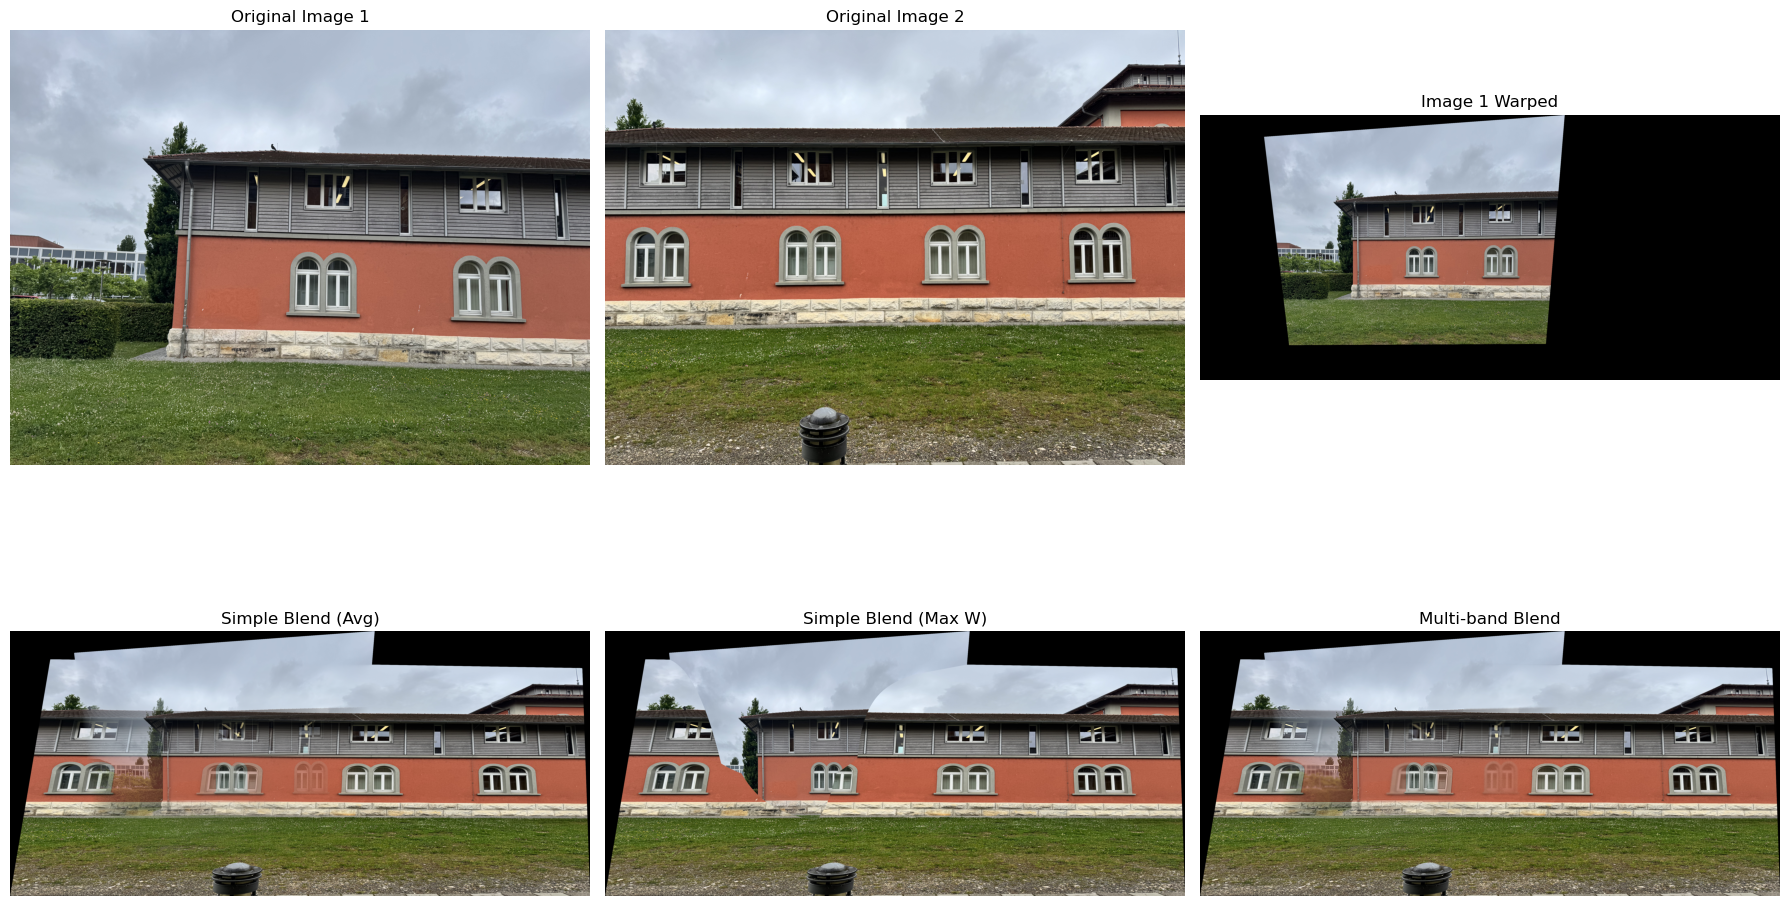

In [31]:
def run_panorama_stitching_user_data():
    print("\n--- Running Panorama Stitching Example with User Data ---")

    img1_path = dateien[0]
    img2_path = dateien[1]

    img1_orig = cv2.imread(img1_path)
    img2_orig = cv2.imread(img2_path)

    if img1_orig is None or img2_orig is None:
        print(f"Error: Could not load images. Ensure paths are correct.")
        print(f"Attempted paths: {img1_path}, {img2_path}")
        return

    img1_float = img1_orig.astype(np.float32) / 255.0
    img2_float = img2_orig.astype(np.float32) / 255.0

    src_pts1 = all_image_points_user[0]
    world_pts1 = all_world_points_user[0]

    src_pts2 = all_image_points_user[1]
    world_pts2 = all_world_points_user[1]

    H1 = compute_homography(src_pts1, world_pts1)
    H2 = compute_homography(src_pts2, world_pts2)

    h1_orig, w1_orig = img1_orig.shape[:2]
    corners1 = np.float32([[0,0], [0,h1_orig-1], [w1_orig-1,h1_orig-1], [w1_orig-1,0]]).reshape(-1,1,2)
    transformed_corners1 = cv2.perspectiveTransform(corners1, H1)

    h2_orig, w2_orig = img2_orig.shape[:2]
    corners2 = np.float32([[0,0], [0,h2_orig-1], [w2_orig-1,h2_orig-1], [w2_orig-1,0]]).reshape(-1,1,2)
    transformed_corners2 = cv2.perspectiveTransform(corners2, H2)

    all_corners = np.concatenate((transformed_corners1, transformed_corners2), axis=0)

    x_min, y_min = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]],
                              [0, 1, translation_dist[1]],
                              [0, 0, 1]], dtype=np.float32)

    output_width = x_max - x_min
    output_height = y_max - y_min

    if not(0 < output_width < 10000 and 0 < output_height < 10000) : # Basic sanity check
        print(f"Warning: Calculated output dimensions are extreme ({output_width}x{output_height}). Clamping to a default size (e.g., 1200x800).")
        print("This often happens with incorrect point correspondences leading to a degenerate homography.")
        output_width = 1200
        output_height = 800

    H1_final = H_translation @ H1
    H2_final = H_translation @ H2

    img1_warped = cv2.warpPerspective(img1_float, H1_final, (output_width, output_height))
    img2_warped = cv2.warpPerspective(img2_float, H2_final, (output_width, output_height))

    weights1_orig = calculate_pixel_weights(h1_orig, w1_orig)
    weights2_orig = calculate_pixel_weights(h2_orig, w2_orig)

    weights1_warped = cv2.warpPerspective(weights1_orig.astype(np.float32), H1_final, (output_width, output_height))
    weights2_warped = cv2.warpPerspective(weights2_orig.astype(np.float32), H2_final, (output_width, output_height))

    weights1_warped = np.clip(weights1_warped, 0, 1)
    weights2_warped = np.clip(weights2_warped, 0, 1)

    blended_simple_avg = blend_images_simple(img1_warped, weights1_warped,
                                             img2_warped, weights2_warped, method='weighted_average')

    blended_simple_max = blend_images_simple(img1_warped, weights1_warped,
                                             img2_warped, weights2_warped, method='max_weight')

    blended_multiband = blend_images_multiband(img1_warped, weights1_warped,
                                               img2_warped, weights2_warped,
                                               low_pass_kernel_size=(21,21))

    plt.figure(figsize=(18, 12))

    display_img1_orig = cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB) if len(img1_orig.shape) == 3 and img1_orig.shape[2] == 3 else img1_orig
    display_img2_orig = cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB) if len(img2_orig.shape) == 3 and img2_orig.shape[2] == 3 else img2_orig

    cmap_val = 'gray' if len(img1_orig.shape) == 2 else None

    plt.subplot(2, 3, 1)
    plt.imshow(display_img1_orig, cmap=cmap_val)
    plt.title("Original Image 1")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(display_img2_orig, cmap=cmap_val)
    plt.title("Original Image 2")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(img1_warped[...,::-1] if len(img1_warped.shape) == 3 and img1_warped.shape[2] == 3 else img1_warped, cmap=cmap_val)
    plt.title("Image 1 Warped")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(blended_simple_avg[...,::-1] if len(blended_simple_avg.shape) == 3 and blended_simple_avg.shape[2] == 3 else blended_simple_avg, cmap=cmap_val)
    plt.title("Simple Blend (Avg)")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(blended_simple_max[...,::-1] if len(blended_simple_max.shape) == 3 and blended_simple_max.shape[2] == 3 else blended_simple_max, cmap=cmap_val)
    plt.title("Simple Blend (Max W)")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(blended_multiband[...,::-1] if len(blended_multiband.shape) == 3 and blended_multiband.shape[2] == 3 else blended_multiband, cmap=cmap_val)
    plt.title("Multi-band Blend")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # visualize_points(haus_punkte_img[:2], dateien[:2]) # Visualisiere Punkte für die ersten beiden Bilder
    run_panorama_stitching_user_data()